# Monochromatization of Broadband Diffraction Patterns

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from matplotlib import colors
import monochromatization_of_diffraction_pattern as modp
from rebin import rebin
from Cparloop_sparse import parloop

Load a broadband diffraction pattern and the corresponding spectrum.  
Make sure that the pattern is centered and square (and corrected for background, flatfield...).

In [2]:
Example_variables = np.load('Example_whitelight_experiment.npz')
B = Example_variables['B']
spect_I = Example_variables['spect_I']
spect_lambda = Example_variables['spect_lambda']
Npixels = int(B.shape[0]/2)

Text(0.5, 1.0, 'B')

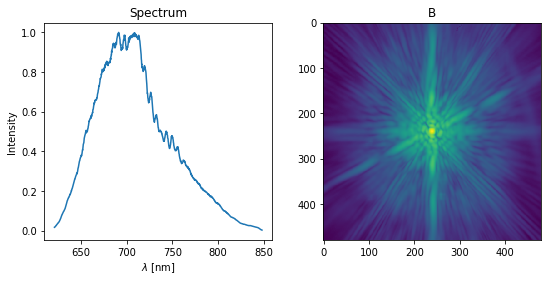

In [3]:
plt.close('Broadband Diffraction Pattern')
fig=plt.figure('Broadband Diffraction Pattern',figsize=[9,4])
ax=fig.add_subplot(121)
ax.plot(spect_lambda*1e9,spect_I/spect_I.max())
ax.set_title('Spectrum')
ax.set_xlabel('$\lambda$ [nm]')
ax.set_ylabel('Intensity')

ax2=fig.add_subplot(122)
ax2.imshow(B, norm=colors.LogNorm())
ax2.set_title('B')

Normalize spectrum to variables *S* and *a*.
Build matrix C, and save it somewhere.  
You only need to build C once per spectrum and pattern size.

In [4]:
Calculate_C = False

S = spect_I/spect_I.sum()
lambda_c = (spect_lambda*S).sum() # central wavelength to which we will monochromatize
a = spect_lambda/lambda_c


if Calculate_C == True:
    C=modp.build_C(S, a, Npixels, n_jobs=-2, verbose=10, Cmode='analysis') # calculate C
    sparse.save_npz('C_example.npz', C) # save C to disk
else:
    C = sparse.load_npz('C_example.npz') # load C from disk

Monochromatize the broadband pattern through regularized matrix inversion.

In [5]:
k_max=30
B_ravel = modp.cut_rotate_ravel(B) # Because the scaling is identical for each quadrant, the four quadrants of B are cut, then rotated and raveled to 1D.
mk_ravel = modp.CGLS_sparse(C,B_ravel,k_max=k_max) # The actual monochromatization, up to k=k_max
mk_2D = np.zeros((2*Npixels,2*Npixels,k_max))
for k_i in range(k_max):
    mk_2D[:,:,k_i] = modp.inverse_ravel_rotate_cut(mk_ravel[:,k_i]) # Reordering of the monochromatized patterns into a stack of 2D patterns

*mk_2D* is a stack of monochromatized patterns for increasing *k*.
As *k* increases, the diffraction pattern is 'monochromatized' more and more. After some optimum (which depends on the quality and sampling of the broadband pattern and the corresponding spectrum), inverted noise will start to dominate.
It is up to you to choose the optimum *k* (visually as a stack in e.g. ImageJ, or brute-force by launching your phase retrieval for different values of *k*).

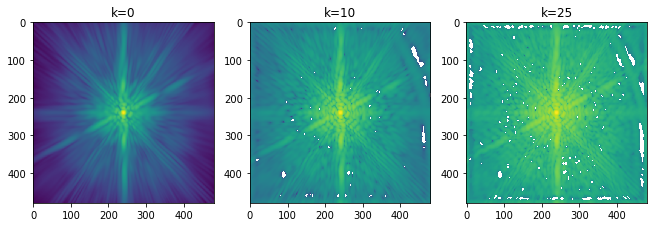

In [ ]:
plot_kvals = [0,10,25]

plt.close('mk_2D')
fig=plt.figure('mk_2d',figsize=[11,4])

for k_i in range(len(plot_kvals)):
    ax=fig.add_subplot(1,len(plot_kvals),k_i+1)
    ax.imshow(mk_2D[:,:,plot_kvals[k_i]],norm=colors.LogNorm())
    ax.set_title('k=%d'%plot_kvals[k_i])

### Congratulations! You now have your monochromatized diffraction pattern which you can use in your favorite phase retrieval code!